In [4]:
import os
import numpy as np
import time
from dotenv import load_dotenv

# Imports from Qiskit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.quantum_info import Statevector

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService

# Importing custom modules
from backend_simularot import get_modified_backend
from generate_QV_circuits import get_standard_QV_circuit, get_parity_QV_circuit, get_double_parity_QV_circuit
from calculate_heavy_outputs import get_hu_standard_perfect_circuit, get_hu_standard_circuit, get_hu_parity_circuit, get_hu_double_parity_circuit
from plot_heavy_outputs import show_heavy_outputs

In [5]:
# Loading variables from .env file
load_dotenv()

True

## Connect to IBM and create a simulator of chosen Qprocessor

In [3]:
service = QiskitRuntimeService(channel="ibm_cloud", token=os.getenv("QISKIT_TOKEN"))
real_backend = service.backend("ibm_brisbane")
simulator = AerSimulator.from_backend(real_backend)

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-09-03 12:17:46,499: Default instance not set. Searching all available instances.


## Create a fake backend by modifying errors in chosen IBM Qprocessor 

In [5]:
modified_backend = get_modified_backend(real_backend, 0.8, 0.8, 0.8, 0.8)
simulator_mod = AerSimulator.from_backend(modified_backend)
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=simulator_mod, layout_method='trivial')

# For calculation on real IBM Sherbrooke quantum computer
#pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=3,layout_method='trivial')

## Quantum Volume Cuircuit Parameters

In [18]:
N = 8 #number of qubits
T_tab = [2,4,6,8,10,12,16] #table for number of layers
test_num = 50 #number of tested quantum circuits with for given dimentions
shots_num = 200 #number of runs of each quantum circuit

## Quantum computation

In [19]:
circuit_standard_perfect_tab = []
circuit_standard_tab = []
circuit_parity_tab = []
circuit_double_parity_tab = []
odds_tab = []

for T in T_tab:
    print(f"Create circuit with T = {T} layers")
    circuits_st_perfect = []
    circuits_st = []
    circuits_p = []
    circuits_pp = []
    odds_t = []
    
    for i in range(test_num):
        
        qc_st_perfect, qc_st_test =  get_standard_QV_circuit(N,T)
        circuits_st_perfect.append(qc_st_perfect)
        circuits_st.append(pass_manager.run(qc_st_test))
        
        circuits_p.append(pass_manager.run(get_parity_QV_circuit(N,T)))

        circuit, odds = get_double_parity_QV_circuit(N,T)
        circuits_pp.append(pass_manager.run(circuit))
        odds_t.append(odds)

    circuit_standard_perfect_tab.append(circuits_st_perfect)
    circuit_standard_tab.append(circuits_st)
    circuit_parity_tab.append(circuits_p)
    circuit_double_parity_tab.append(circuits_pp)
    odds_tab.append(odds_t)

create circuit with T = 2  layers
create circuit with T = 4  layers
create circuit with T = 6  layers
create circuit with T = 8  layers
create circuit with T = 10  layers
create circuit with T = 12  layers
create circuit with T = 16  layers


In [20]:
perfect_output_states_standard_QV = []

print("perfect simualtion of standard QV circuit for T:")
for a, T in enumerate(T_tab):
    print(f"T = {T}")
    vectors = []
    for qc in circuit_standard_perfect_tab[a]:
        v = np.array(Statevector.from_instruction(qc))
        vectors.append(v/np.linalg.norm(v))
    perfect_output_states_standard_QV.append(vectors)

perfect simualtion of standard QV circuit
T =  2
T =  4
T =  6
T =  8
T =  10
T =  12
T =  16


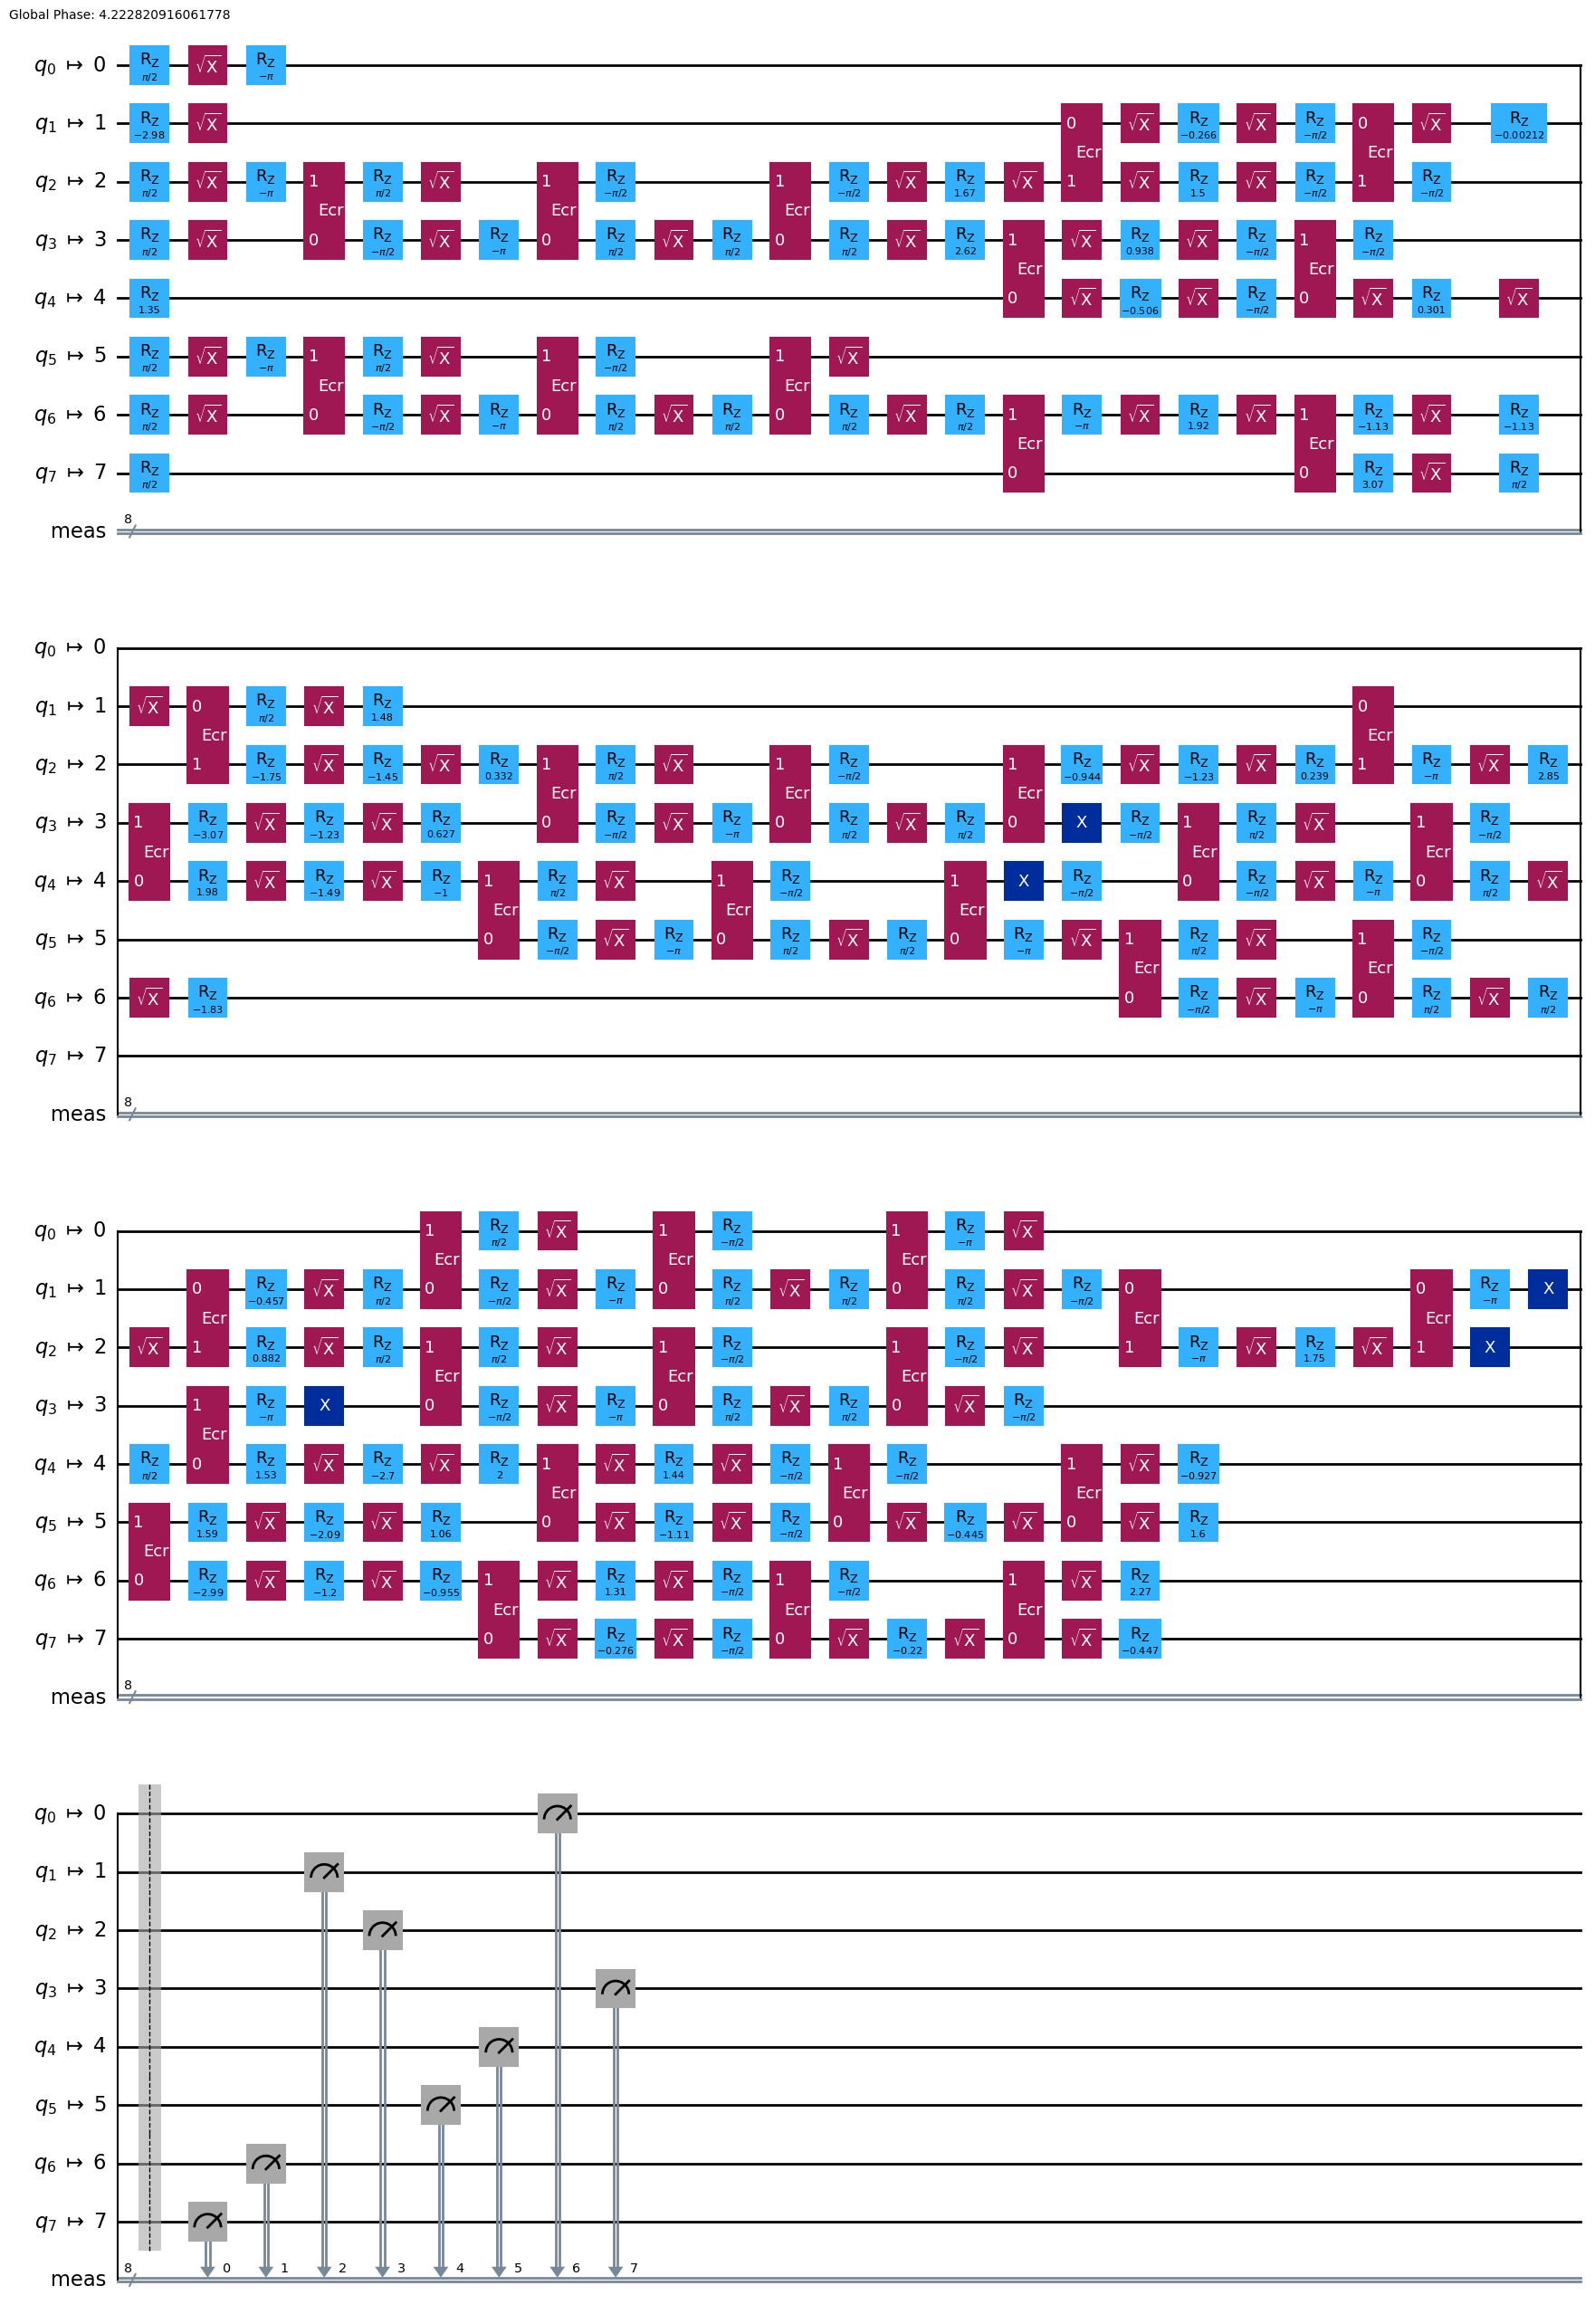

In [21]:
#drawing of examplar circuit
circuit_double_parity_tab[0][0].draw(output="mpl", idle_wires=False, style="iqp")

In [22]:
sampler = Sampler(simulator_mod)
# For calculation on real IBM Sherbrooke quantum computer
#sampler = Sampler(real_backend)

sampler.options.default_shots = shots_num

distribution_standard_tab = []
distribution_parity_tab = []
distribution_double_parity_tab = []

for a, T in enumerate(T_tab):
    print(f"T = {T}")

    #combine all circits of the same dimentions in one job to speed up the calculations ic case of accual IBM quantum computer
    joint_sample = circuit_standard_tab[a] + circuit_parity_tab[a] + circuit_double_parity_tab[a]
    
    start_time = time.time()
    job = sampler.run(joint_sample) #to run the job 
    results = job.result() 
    print(f"calculation time = {time.time() - start_time}")

    dist_st = [results[i].data.meas.get_counts() for i in range(test_num)]
    distribution_standard_tab.append(dist_st)

    dist_p = [results[i].data.meas.get_counts() for i in range(test_num, 2*test_num)]
    distribution_parity_tab.append(dist_p)

    dist_pp = [results[i].data.meas.get_counts() for i in range(2*test_num, 3*test_num)]
    distribution_double_parity_tab.append(dist_pp)

T =  2
calculation time =  28.46377420425415
T =  4
calculation time =  47.27720236778259
T =  6
calculation time =  80.36285758018494
T =  8
calculation time =  101.71558928489685
T =  10
calculation time =  130.42793107032776
T =  12
calculation time =  1104.3213202953339
T =  16
calculation time =  174.92639350891113


## Posprocessing

In [24]:
hu_standard_perfect_tab = np.zeros((len(T_tab),test_num))
hu_standard_tab = np.zeros((len(T_tab),test_num))
hu_parity_tab = np.zeros((len(T_tab),test_num))
hu_double_parity_tab = np.zeros((len(T_tab),test_num))

for a in range(len(T_tab)):
    for i in range(test_num):
        hu_standard_perfect_tab[a,i] = get_hu_standard_perfect_circuit(perfect_output_states_standard_QV[a][i])
        hu_standard_tab[a,i] = get_hu_standard_circuit(distribution_standard_tab[a][i],perfect_output_states_standard_QV[a][i])
        hu_parity_tab[a,i] = get_hu_parity_circuit(distribution_parity_tab[a][i])
        hu_double_parity_tab[a,i] = get_hu_double_parity_circuit(distribution_double_parity_tab[a][i],odds_tab[a][i])

In [25]:
for a in range(len(T_tab)):
    np.save(f"results/sym_hu_standard_perfect_tab_{N}{T_tab[a]}",hu_standard_perfect_tab[a])
    np.save(f"results/sym_hu_standard_tab_{N}{T_tab[a]}",hu_standard_tab[a])
    np.save(f"results/sym_hu_parity_tab_{N}{T_tab[a]}",hu_parity_tab[a])
    np.save(f"results/sym_hu_double_parity_tab_{N}{T_tab[a]}",hu_double_parity_tab[a])

# Results
### Loading calculations resoults
Note that this is a very small examplar sample

In [26]:
all_hu_tab = []

N_tab = np.array([6,8])
T_ttab = [np.array([2,4,6,8,10,12,16,20]),
          np.array([2,4,6,8,10,12,16])
         ]

for a in range(len(N_tab)):
    hu_standard_perfect_tab = []
    hu_sandard_tab = []
    hu_parity_tab = []
    hu_double_parity_tab = []
    for b in range(len(T_ttab[a])):
        hu_standard_perfect_tab.append(np.load(f"results/sym_hu_standard_perfect_tab_{N_tab[a]}{T_ttab[a][b]}.npy")) 
        hu_sandard_tab.append(np.load(f"results/sym_hu_standard_tab_{N_tab[a]}{T_ttab[a][b]}.npy")) 
        hu_parity_tab.append(np.load(f"results/sym_hu_parity_tab_{N_tab[a]}{T_ttab[a][b]}.npy")) 
        hu_double_parity_tab.append(np.load(f"results/sym_hu_double_parity_tab_{N_tab[a]}{T_ttab[a][b]}.npy")) 

    all_hu_tab.append([hu_standard_perfect_tab,hu_sandard_tab,hu_parity_tab,hu_double_parity_tab])

## Examplar plots

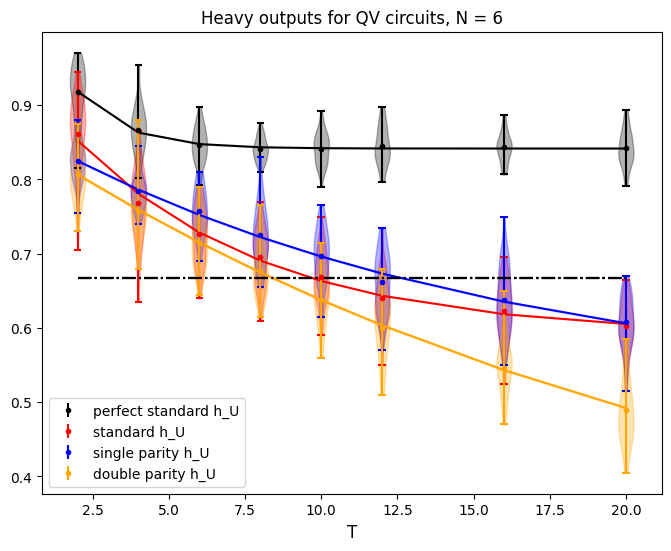

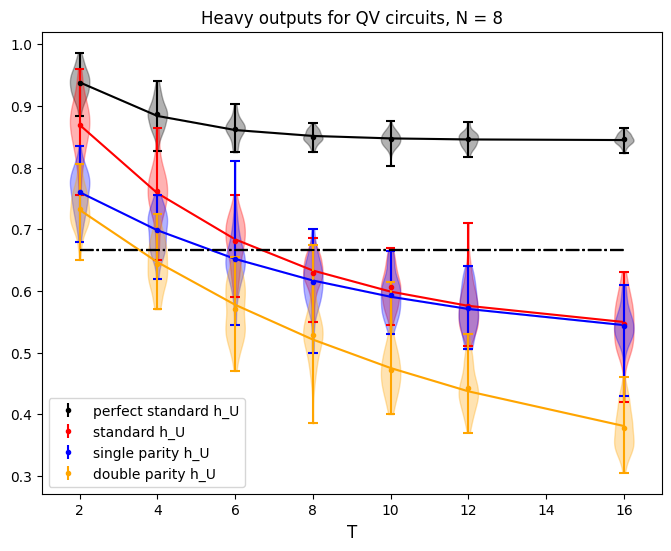

In [28]:
for i in range(2):
    show_heavy_outputs(all_hu_tab[i],T_ttab[i],N_tab[i])